In [1]:
import os
from getpass import getpass
from coreapi.auth import BasicAuthentication
from quantuminspire.api import QuantumInspireAPI
from quantuminspire.credentials import load_account, get_token_authentication, get_basic_authentication
from quantuminspire.api import QuantumInspireAPI
# from quantuminspire.projectq.backend_qx import QIBackend

import numpy as np
import pandas as pd
from math import pi

In [2]:
print('Enter mail address')
email = input()

print('Enter password')
password = getpass()

server_url = r'https://api.quantum-inspire.com'
authentication = BasicAuthentication(email, password)
qi = QuantumInspireAPI(server_url, authentication)

Enter mail address
juandadospuntostres@gmail.com
Enter password
········


In [4]:
def write_data(data,name):
    f = open(name,'a')
    f.write("N.\t +1\t\t -1\n")
    for i in range(len(data)):
        f.write(str(i+1)+"\t"+str(data[i][0])+"\t"+str(data[i][1])+"\n")
    f.close

In [5]:
def tomography_circuit(angle):
    qasm = '''
    version 1.0

    qubits 5
    prep_z q[2]
    Rx q[2], {0}
    Measure_z q[2]
    '''
    return qasm.format(angle)

In [6]:
def calibration_circuit1():
    qasm = '''
    version 1.0

    qubits 5
    prep_z q[2]
    Measure_z q[2]
    '''
    return qasm.format()

def calibration_circuit2():
    qasm = '''
    version 1.0

    qubits 5
    prep_z q[2]
    Rx q[2], {0}
    Measure_z q[2]
    '''
    return qasm.format(pi)

In [7]:
def calibration():
    
    n = 10
    N_shots = 8192
    backend_type = qi.get_backend_type_by_name('Starmon-5')
    index=0
    calibration1 = []
    calibration2 = []
    
    print("Running first calibration experiment")
    for i in range(n):
        print("Round "+str(i)+" of "+str(n)+".")
        qasm=calibration_circuit1()
        result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
        hist=result.get('histogram', {})
        calibration1.append([hist["0"],hist["1"]])
        
    write_data(calibration1,"calibration_1_starmon_q0.dat")
    mz_1 = np.average(get_mz(calibration1))
    print("Average m_z"+str(mz_1))
    
    print("Running second calibration experiment")    
    for i in range(n):
        print("Round "+str(i)+" of "+str(n)+".")
        qasm=calibration_circuit2()
        result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
        hist=result.get('histogram', {})
        calibration2.append([hist["0"],hist["1"]])
        
    write_data(calibration2,"calibration_2_starmon_q0.dat")
    mz_2 = np.average(get_mz(calibration2))
    print("Average Rx(pi) m_z"+str(mz_2))
    
    beta1 = 0.5*(mz_1+mz_2)
    beta2 = 0.5*(mz_1-mz_2)
    calibrations_params = [beta1,beta2]
    
    return calibrations_params


In [22]:
target_points = np.linspace(0,2*pi,10)
N_shots = 8192
backend_type = qi.get_backend_type_by_name('Starmon-5')
copied_data=[]
index=0

for points in target_points:
    qasm=tomography_circuit(points)
    result = qi.execute_qasm(qasm, backend_type=backend_type, number_of_shots=N_shots)
    hist=result.get('histogram', {})
    copied_data.append([hist["0"],hist["1"]])
    print(index)
    index += 1

0
1
2
3
4
5
6
7
8
9


In [ ]:
def correct_data(data,params):
    corrected = []
    for i in range(len(data)):
        corrected.append((data[i]-params[0])/params[1])
    return corrected

In [24]:
def get_mz(data):
    mz = []
    for i in range(len(data)):
        mz.append(data[i][0]-data[i][1])
    return mz

In [ ]:
q2calibration=calibration()

Running first calibration experiment
Round 0 of 10.


In [52]:
params_0_calibration = [0.12291259765624996, 0.82781982421875]

In [54]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'm_z')

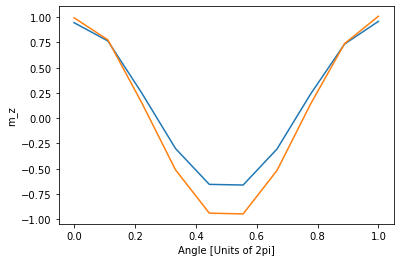

In [63]:
plt.plot(np.linspace(0,1,10),get_mz(copied_data),np.linspace(0,1,10),correct_data(get_mz(copied_data),params))
plt.xlabel("Angle [Units of 2pi]")
plt.ylabel("m_z")